# Semantic Segmentation Using U-Net
### Artificial Intelligence Course | Instructed by DR. MohammadHossein Rohban
<font color='cyan'> Responsible TAs: Amirhossein Razlighi, Reza Vahidimajd </font>

<font color='yellow'> Please ask your questions via [Quera](www.quera.com) </font>

Ali Shahheidar (400105777)

Mehrafarin Kazemi (99109488)

In this excercise, you will design and train a CNN-based network called U-Net. This type of networks are used for semantic segmentation. This task is, as it's called, segmenting the image, semantically to different parts. You can consider this as a classification, done on each pixel of the image! Below, you can see an example of the task:


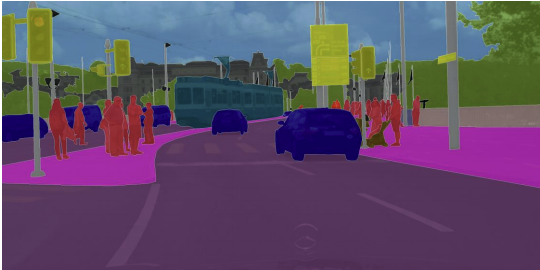 <br>
Example of a segmented image <br>


We will use a dataset which is used for "Self-Driving Car" Purposes. As you may know, understanding each pixel (in the view point of car) is an important task for self-driving cars. Let's proceed with this task to the end of this excercise!

## Downloading Dataset

In [35]:
%pip install --upgrade --no-cache-dir gdown

In [36]:
#!gdown --id 11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3

!kaggle datasets download -d mojtabanafez/self-driving-car-dataset-ai-course

Dataset URL: https://www.kaggle.com/datasets/mojtabanafez/self-driving-car-dataset-ai-course
License(s): Apache 2.0
self-driving-car-dataset-ai-course.zip: Skipping, found more recently modified local copy (use --force to force download)


In [37]:
!unzip self-driving-car-dataset-ai-course.zip

Archive:  self-driving-car-dataset-ai-course.zip
replace Files/data/CameraMask/000026.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Files/data/CameraMask/000026.png  
  inflating: Files/data/CameraMask/000027.png  
  inflating: Files/data/CameraMask/000028.png  
  inflating: Files/data/CameraMask/000029.png  
  inflating: Files/data/CameraMask/000032.png  
  inflating: Files/data/CameraMask/000033.png  
  inflating: Files/data/CameraMask/000034.png  
  inflating: Files/data/CameraMask/000043.png  
  inflating: Files/data/CameraMask/000044.png  
  inflating: Files/data/CameraMask/000045.png  
  inflating: Files/data/CameraMask/000073.png  
  inflating: Files/data/CameraMask/000084.png  
  inflating: Files/data/CameraMask/000085.png  
  inflating: Files/data/CameraMask/000156.png  
  inflating: Files/data/CameraMask/000688.png  
  inflating: Files/data/CameraMask/000689.png  
  inflating: Files/data/CameraMask/000690.png  
  inflating: Files/data/CameraMask/000691.png  
  inf

In [38]:
%pip install --upgrade torch torchvision torchsummary

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [39]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

### Set torch device to appropriate type for GPU training

In [40]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
)
# device = torch.device("cpu")
device


device(type='cuda')

<a name='2'></a>
## 2 - Load the Data

In [41]:
path = "" # Path to the root folder
image_path = os.path.join(path, "Files/data/CameraRGB/")
mask_path = os.path.join(path, "Files/data/CameraMask/")
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=5`

<ipython-input-42-3880b6f4f52a>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-42-3880b6f4f52a>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

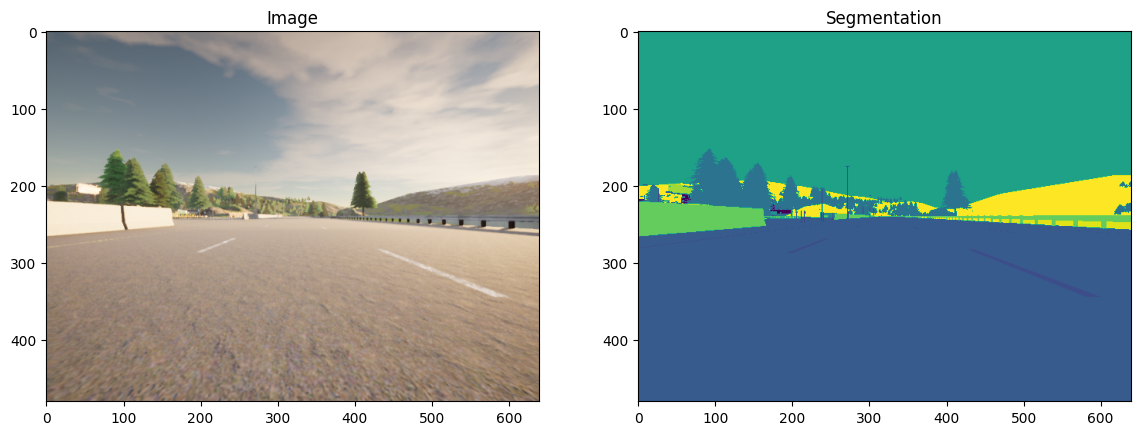

In [42]:
N = 5
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-2'></a>
### 2.2 - Preprocess Your Data



In [43]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        self.ImagesDirectory = ImagesDirectory
        self.MasksDirectory = MasksDirectory

        self.images_list = sorted([os.path.join(ImagesDirectory, img) for img in os.listdir(ImagesDirectory)])
        self.masks_list = sorted([os.path.join(MasksDirectory, msk) for msk in os.listdir(MasksDirectory)])

        self.mask_transforms = transforms.Compose([
            transforms.Resize((192, 256), interpolation=Image.NEAREST),
            transforms.ToTensor(),
            lambda mask: mask[0],
            lambda mask: (mask * 255).type(torch.LongTensor)
        ])

        self.image_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            lambda x: x[:3, :, :]
        ])

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        image_path = self.images_list[index]
        mask_path = self.masks_list[index]

        image = imageio.imread(image_path)
        mask = imageio.imread(mask_path)

        image = self.image_transforms(image)
        mask = self.mask_transforms(Image.fromarray(mask))

        return image, mask

<a name='2-3'></a>

> Add blockquote


### 2.3 - Hyper-parameters and Optimizer

In [44]:
EPOCHS = 15
BATCH_SIZE = 16
LR = 0.0004
B1 = 0.9
B2 = 0.999

<a name='3'></a>
## 3 - U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

You will see the transpose convolution referred to by several names, including "deconvolution" and "upconvolution", but these are all the same thing. You will also see the model's architecture in the following cells.

<a name='3-1'></a>
### 3.1 - Model Details

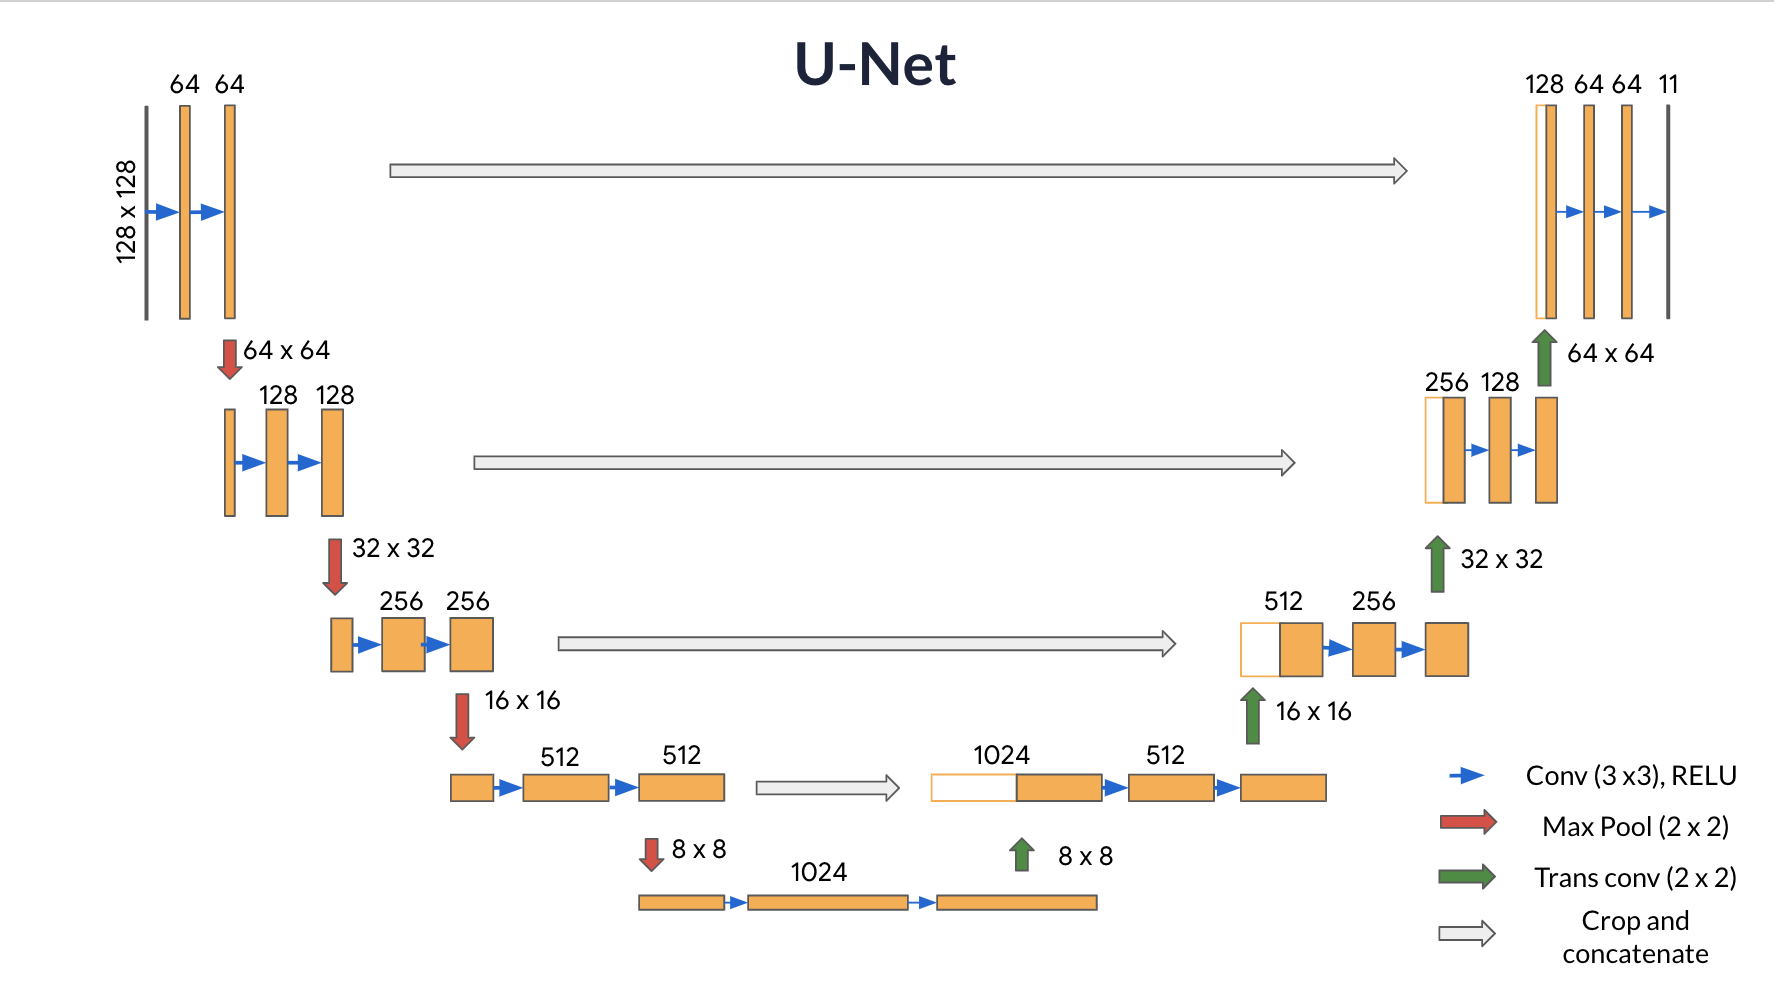<br>
U-Net Architecture<br>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 valid padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

**Important Note:**
The figures shown in the assignment for the U-Net architecture depict the layer dimensions and filter sizes as per the original paper on U-Net with smaller images. However, due to computational constraints for this assignment, you will code only half of those filters. The purpose of showing you the original dimensions is to give you the flavour of the original U-Net architecture. The important takeaway is that you multiply by 2 the number of filters used in the previous step. The notebook includes all of the necessary instructions and hints to help you code the U-Net architecture needed for this assignment.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block)

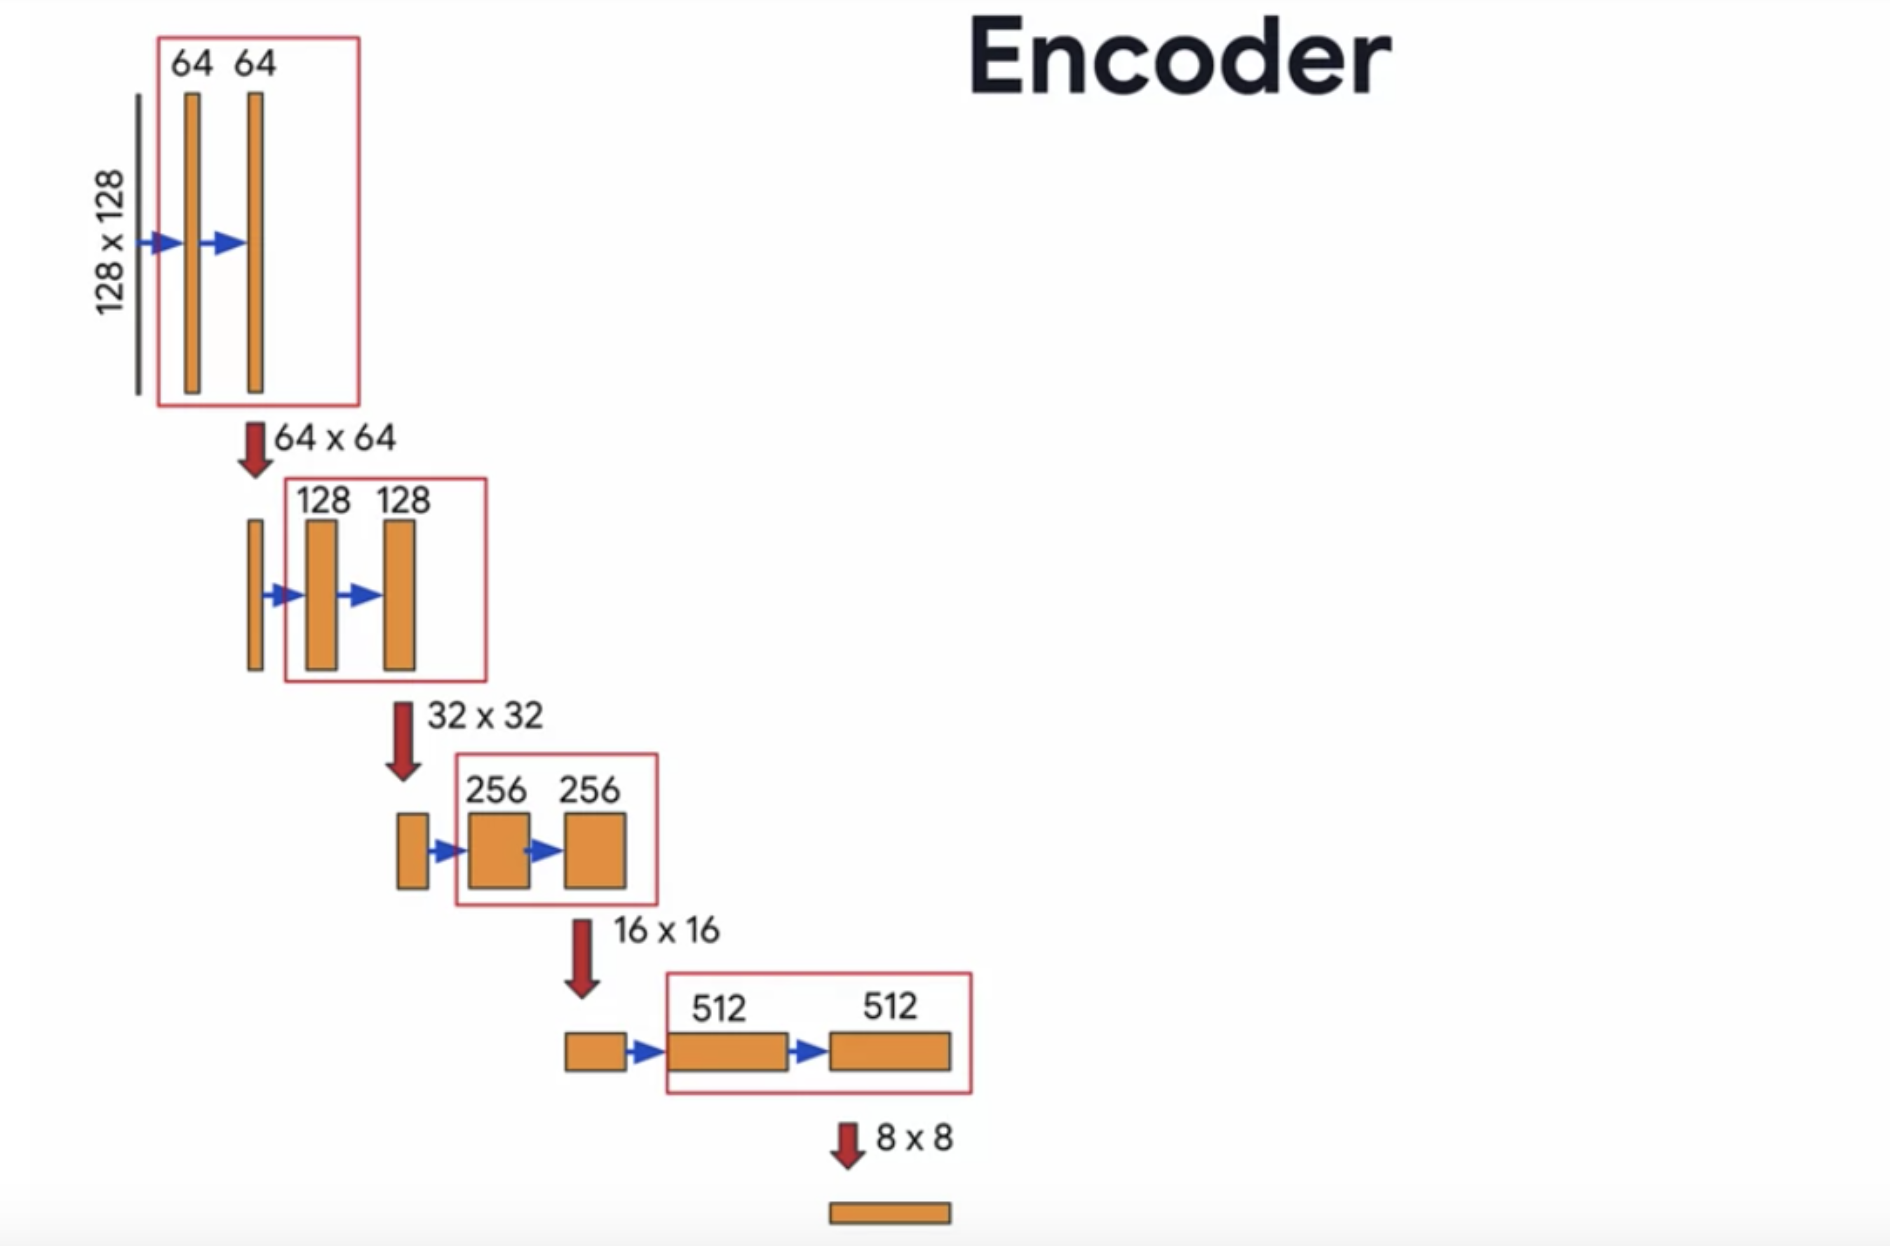<br>
The U-Net Encoder up close <br>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling.

The function will  return two tensors:
- `next_layer`: That will go into the next block.
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

In [45]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=32, dropout_prob=0, max_pooling=True):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, n_filters, kernel_size=3, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(n_filters)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(n_filters)
        self.relu = nn.ReLU()
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout2d(dropout_prob)
        self.max_pooling = max_pooling
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        next_layer = self.conv1(x)
        next_layer = self.batch_norm1(next_layer)
        next_layer = self.relu(next_layer)

        next_layer = self.conv2(next_layer)
        next_layer = self.batch_norm2(next_layer)
        next_layer = self.relu(next_layer)

        if self.dropout_prob > 0:
            next_layer = self.dropout(next_layer)

        skip_connection = next_layer

        if self.max_pooling:
            next_layer = self.pool(next_layer)

        return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

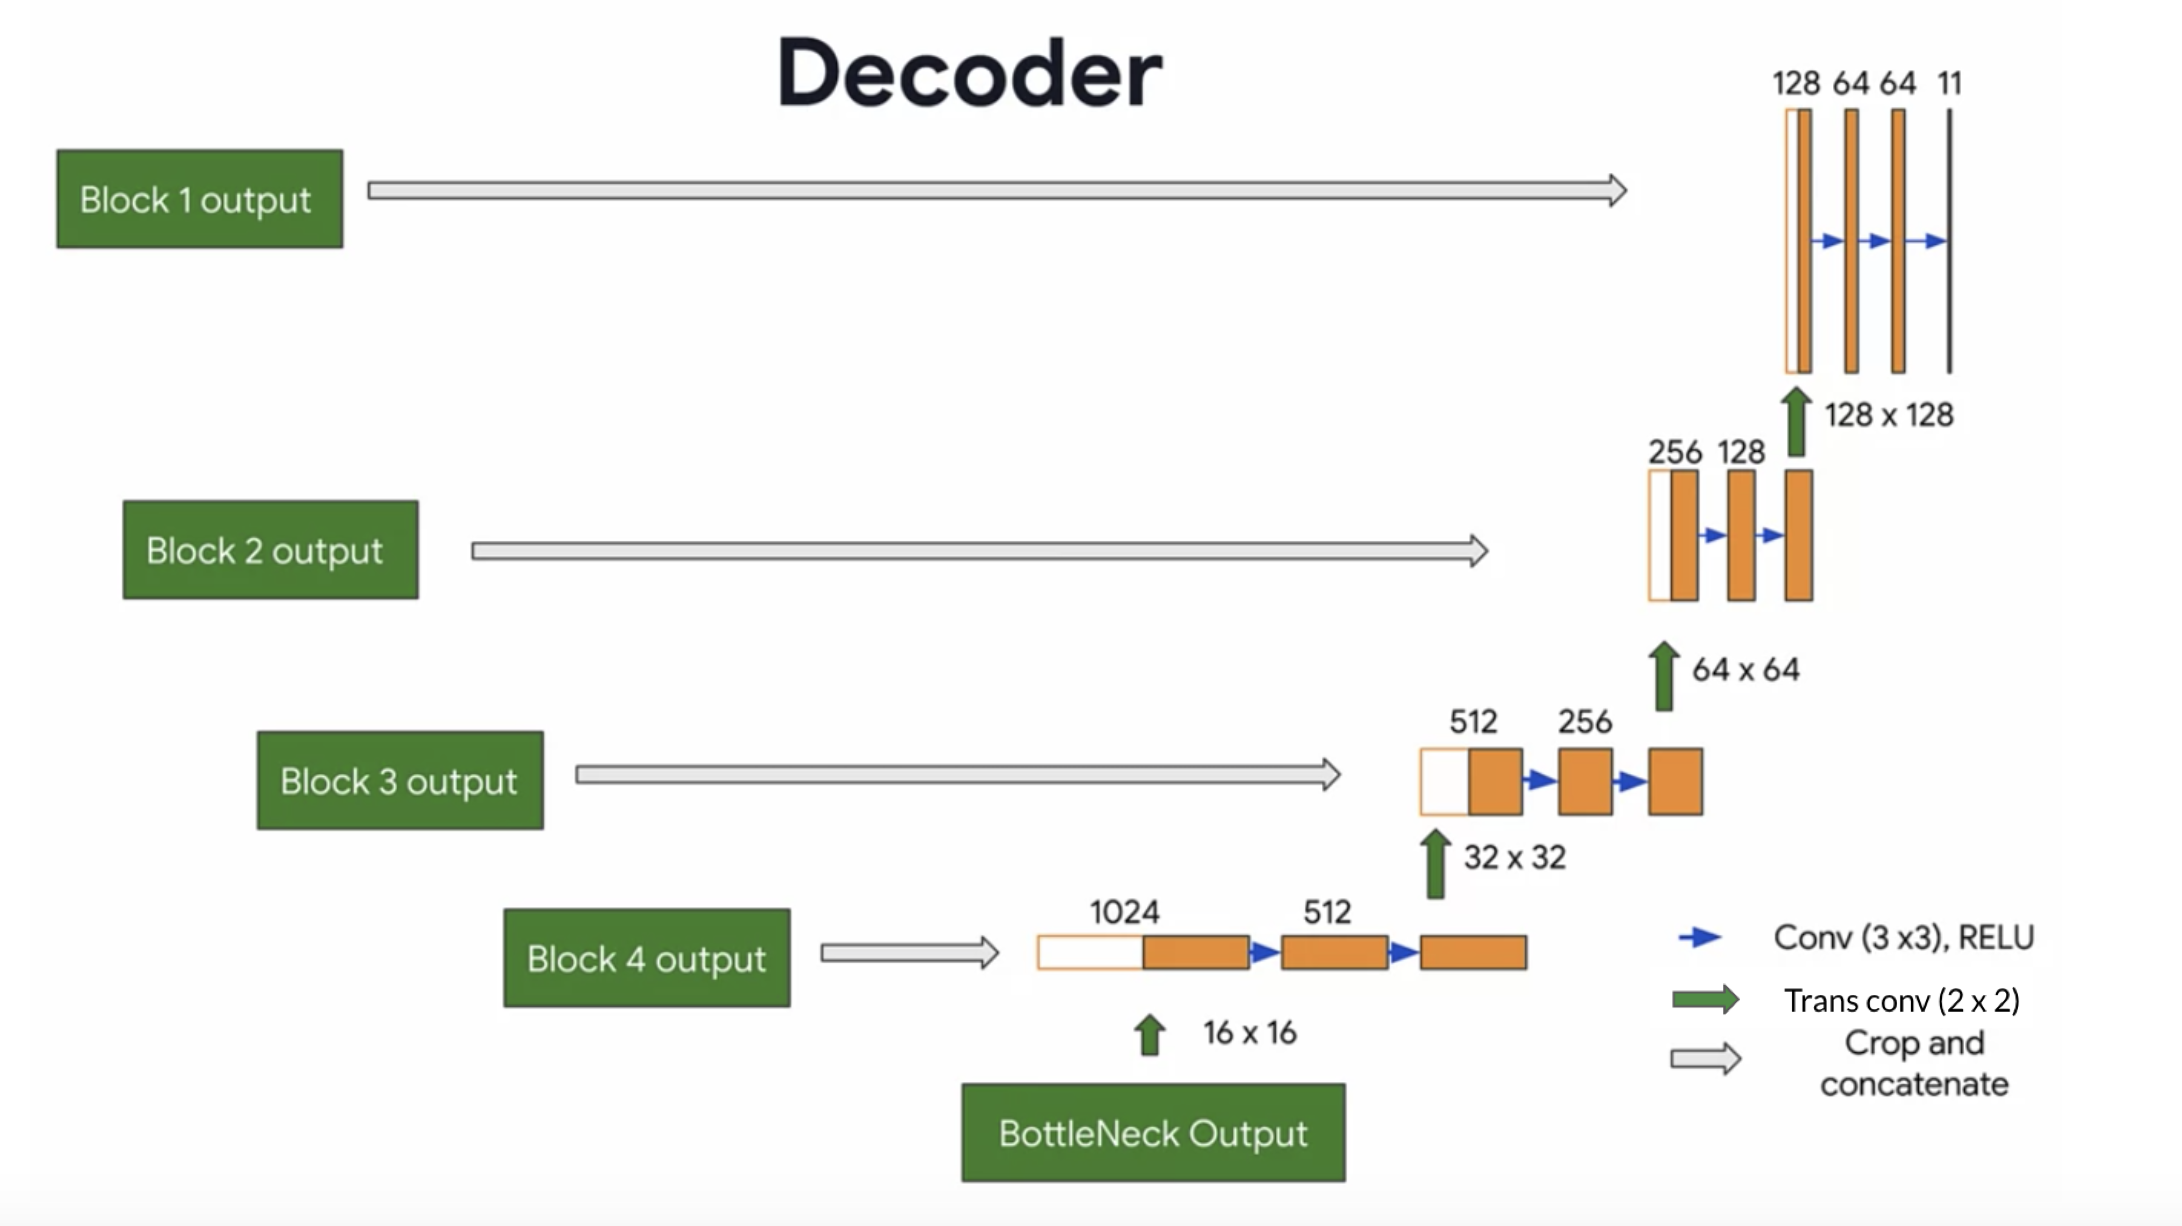<br>
The U-Net Decoder up close <br>

There are two new components in the decoder: `up` and `cat`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder.

Here you'll encounter the `ConvTranspose2d` layer, which performs the inverse of the `Conv2d` layer.



In [46]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_ch, n_filters, kernel_size=2, stride=2)
        self.conv = conv_block(skip_ch + n_filters, n_filters, max_pooling=False)
        self.relu = nn.ReLU()

    def forward(self, expansive_input, contractive_input):
        next_layer = self.upconv(expansive_input)
        next_layer = self.relu(next_layer)
        next_layer = torch.cat((next_layer, contractive_input), dim=1)

        conv, _ = self.conv(next_layer)

        return conv

<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. **That's because there are 23 possible labels for each pixel in this self-driving car dataset.**

In [47]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=32, n_classes=23):
        super(UNet, self).__init__()

        self.conv_block1 = conv_block(in_ch, n_filters)
        self.conv_block2 = conv_block(n_filters, n_filters * 2)
        self.conv_block3 = conv_block(n_filters * 2, n_filters * 4)
        self.conv_block4 = conv_block(n_filters * 4, n_filters * 8, dropout_prob=0.3)
        self.conv_block5 = conv_block(n_filters * 8, n_filters * 16, dropout_prob=0.3, max_pooling=False)

        self.up_block1 = upsampling_block(n_filters * 16, n_filters * 8, n_filters * 8)
        self.up_block2 = upsampling_block(n_filters * 8, n_filters * 4, n_filters * 4)
        self.up_block3 = upsampling_block(n_filters * 4, n_filters * 2, n_filters * 2)
        self.up_block4 = upsampling_block(n_filters * 2, n_filters, n_filters)

        self.final_conv = nn.Conv2d(n_filters, n_classes, kernel_size=1)

    def forward(self, x):
        x1, c1 = self.conv_block1(x)
        x2, c2 = self.conv_block2(x1)
        x3, c3 = self.conv_block3(x2)
        x4, c4 = self.conv_block4(x3)
        x5, _ = self.conv_block5(x4)

        x = self.up_block1(x5, c4)
        x = self.up_block2(x, c3)
        x = self.up_block3(x, c2)
        x = self.up_block4(x, c1)

        out = self.final_conv(x)

        return out

### Check out the model summary

In [48]:
unet = UNet().to(device)
summary(unet, (3, 192, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 256]             864
       BatchNorm2d-2         [-1, 32, 192, 256]              64
              ReLU-3         [-1, 32, 192, 256]               0
            Conv2d-4         [-1, 32, 192, 256]           9,216
       BatchNorm2d-5         [-1, 32, 192, 256]              64
              ReLU-6         [-1, 32, 192, 256]               0
         MaxPool2d-7          [-1, 32, 96, 128]               0
        conv_block-8  [[-1, 32, 96, 128], [-1, 32, 192, 256]]               0
            Conv2d-9          [-1, 64, 96, 128]          18,432
      BatchNorm2d-10          [-1, 64, 96, 128]             128
             ReLU-11          [-1, 64, 96, 128]               0
           Conv2d-12          [-1, 64, 96, 128]          36,864
      BatchNorm2d-13          [-1, 64, 96, 128]             128
             ReLU-14     

[link text](https://)<a name='3-6'></a>
### 3.6 - Dataset Loader For training and test

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible.

In [49]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset

dataset = Segmentation_Dataset(image_path, mask_path)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

<ipython-input-43-b5c7765bf806>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
<ipython-input-43-b5c7765bf806>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


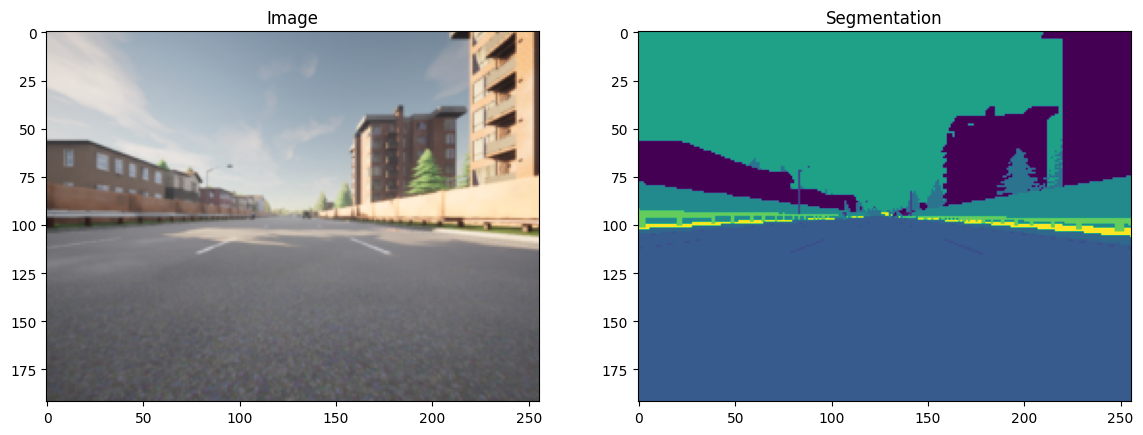

In [50]:
def show_sample(dataloader):
    sample = next(iter(dataloader))
    images, masks = sample
    fig, arr = plt.subplots(1, 2, figsize=(14, 10))
    arr[0].imshow(images[0].permute(1, 2, 0))
    arr[0].set_title('Image')
    arr[1].imshow(masks[0])
    arr[1].set_title('Segmentation')
    plt.show()

show_sample(train_dataloader)

<a name='3-7'></a>
### 3.7 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability.

We recommend using the cross entropy loss and the Adam optimizer.

In [51]:
criterion = nn.CrossEntropyLoss()

In [52]:
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2))

<a name='4'></a>
## 4 - Train the Model

Implement the `train` loop below to train the model.

In [53]:
import timeit
losses = []
unet.train()
def train_model():
    for epoch in range(EPOCHS):
        epoch_losses = []
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            pred = unet(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            print(f"EPOCH#{epoch},\t Batch#{i},\t Loss: {loss.item()}")
        losses.append(np.mean(epoch_losses))

start_time = timeit.default_timer()
train_model()
elapsed_time = timeit.default_timer() - start_time

print(f"Training completed in: {elapsed_time:.2f} seconds")

EPOCH#0,	 Batch#0,	 Loss: 3.179222822189331
EPOCH#0,	 Batch#1,	 Loss: 3.012401819229126
EPOCH#0,	 Batch#2,	 Loss: 2.902529716491699
EPOCH#0,	 Batch#3,	 Loss: 2.8034169673919678
EPOCH#0,	 Batch#4,	 Loss: 2.732221841812134
EPOCH#0,	 Batch#5,	 Loss: 2.6419572830200195
EPOCH#0,	 Batch#6,	 Loss: 2.6093344688415527
EPOCH#0,	 Batch#7,	 Loss: 2.532766342163086
EPOCH#0,	 Batch#8,	 Loss: 2.4104018211364746
EPOCH#0,	 Batch#9,	 Loss: 2.3378236293792725
EPOCH#0,	 Batch#10,	 Loss: 2.3318357467651367
EPOCH#0,	 Batch#11,	 Loss: 2.2224013805389404
EPOCH#0,	 Batch#12,	 Loss: 2.204012393951416
EPOCH#0,	 Batch#13,	 Loss: 2.154500961303711
EPOCH#0,	 Batch#14,	 Loss: 2.103259801864624
EPOCH#0,	 Batch#15,	 Loss: 2.057220697402954
EPOCH#0,	 Batch#16,	 Loss: 2.0580832958221436
EPOCH#0,	 Batch#17,	 Loss: 2.111313581466675
EPOCH#0,	 Batch#18,	 Loss: 1.9815150499343872
EPOCH#0,	 Batch#19,	 Loss: 2.004487991333008
EPOCH#0,	 Batch#20,	 Loss: 1.9523764848709106
EPOCH#0,	 Batch#21,	 Loss: 1.9476417303085327
EPOCH#0,	

<a name='4-1'></a>
### 4.1 - Create Predicted Masks

Now, define a function that uses `torch.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

_(The Predicted class of each pixel is the argmax of different probs assigned to that pixel)_

In [54]:
def create_mask(pred_mask):
     return torch.argmax(pred_mask, dim=1)

<a name='4-2'></a>
### 4.2 - Plot Loss Function

Plot the loss function value of your model in different iterations.

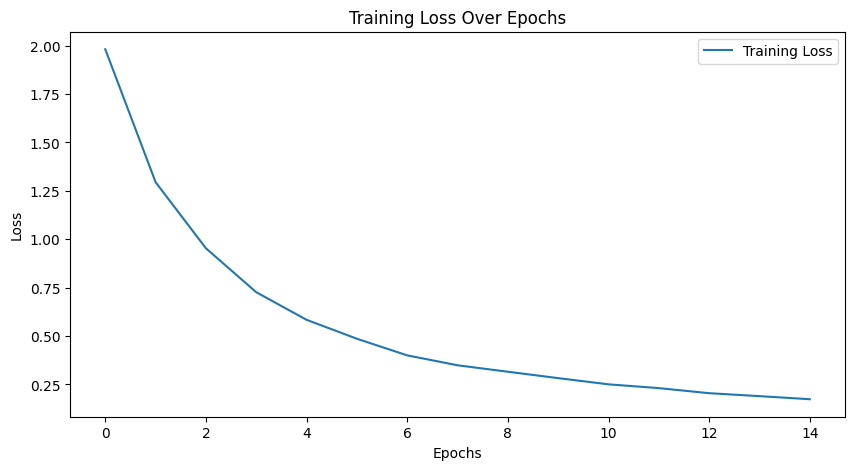

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(range(EPOCHS), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

<a name='4-3'></a>
### 4.3 - mIoU

calculate mIoU for test dataset images and report average mIoU for all the images. (Remember that we have 23 classes in our dataset)

You can read about _mIoU_ metric and how it works [here](https://www.jeremyjordan.me/evaluating-image-segmentation-models/). Also, there are some other good resources on _Medium_, _Wikipedia_ and etc. on this subject. Just search for **What is mIoU in semantic segmentation**.

**Important Note**: You _can_ use some helper functions from _scikit-learn_ library to calculate mIoU, but you can not use functions (from any library) that calculate mIoU or IoU directly. You need to implement the calculation of mIoU by yourself.

In [56]:
def calculate_miou(y_true, y_pred, num_classes):
    iou = [
        np.sum((y_true == i) & (y_pred == i)) / np.sum((y_true == i) | (y_pred == i))
        for i in range(num_classes)
        if np.sum((y_true == i) | (y_pred == i)) > 0
    ]
    return np.mean(iou)

In [57]:
num_classes = 23
mious = []
unet.eval()
for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        X, y_true = batch
        X = X.to(device)
        y_true = y_true.to(device)

        y_pred = unet(X)
        _, y_pred = torch.max(y_pred, dim=1)

        y_true = y_true.cpu().numpy()
        y_pred = y_pred.cpu().numpy()

        miou = calculate_miou(y_true, y_pred, num_classes)
        mious.append(miou)

average_miou = sum(mious) / len(mious)
print(f"average mIoU for test dataset: {average_miou:}")

average mIoU for test dataset: 0.3843963910051892


<a name='4-3'></a>
### 4.5 - Show Predictions

Now, let's see your predictions (masks) vs ground truth masks to understand how well your model did.

In [58]:
import matplotlib.pyplot as plt

def show_predictions(dataloader, device, num_batches=1):

    unet.eval()

    for batch_idx, batch in enumerate(dataloader):
        if batch_idx >= num_batches:
            break

        images, true_masks = batch
        images = images.to(device)
        true_masks = true_masks.to(device)

        with torch.no_grad():
            pred_masks = unet(images)
            pred_masks = torch.argmax(pred_masks, dim=1)

        for img_idx in range(images.size(0)):
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

            axs[0].imshow(images[img_idx].permute(1, 2, 0).cpu().numpy())
            axs[0].set_title("Input Image")
            axs[0].axis("off")

            axs[1].imshow(true_masks[img_idx].cpu().numpy())
            axs[1].set_title("True Mask")
            axs[1].axis("off")

            axs[2].imshow(pred_masks[img_idx].cpu().numpy())
            axs[2].set_title("Predicted Mask")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()

            break

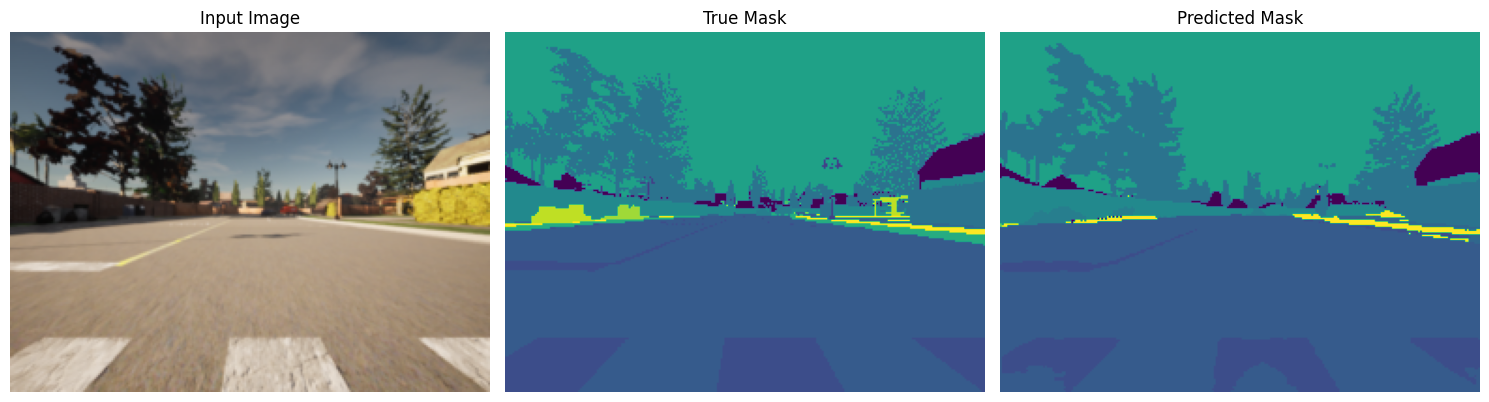

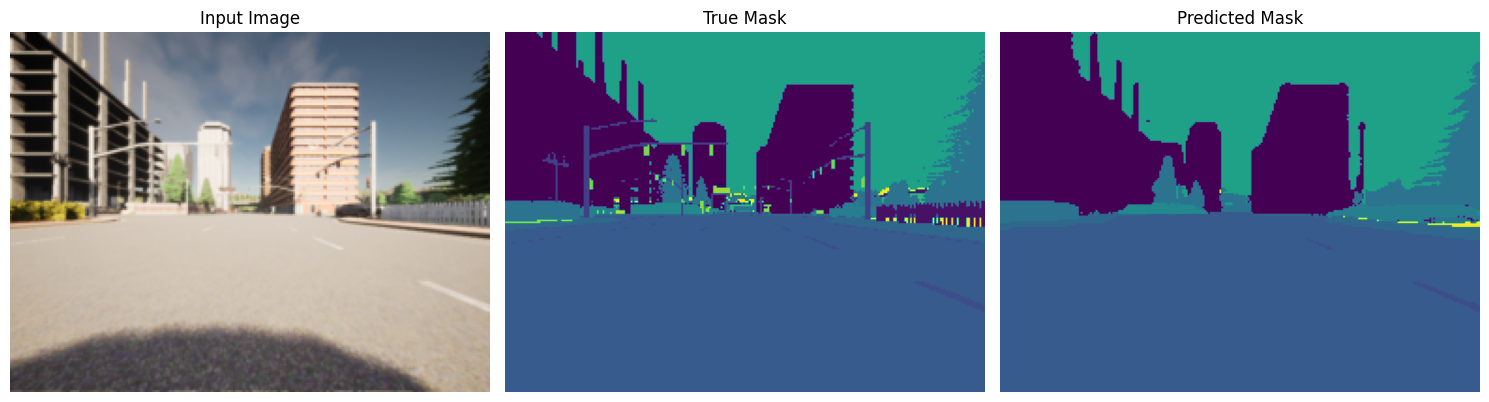

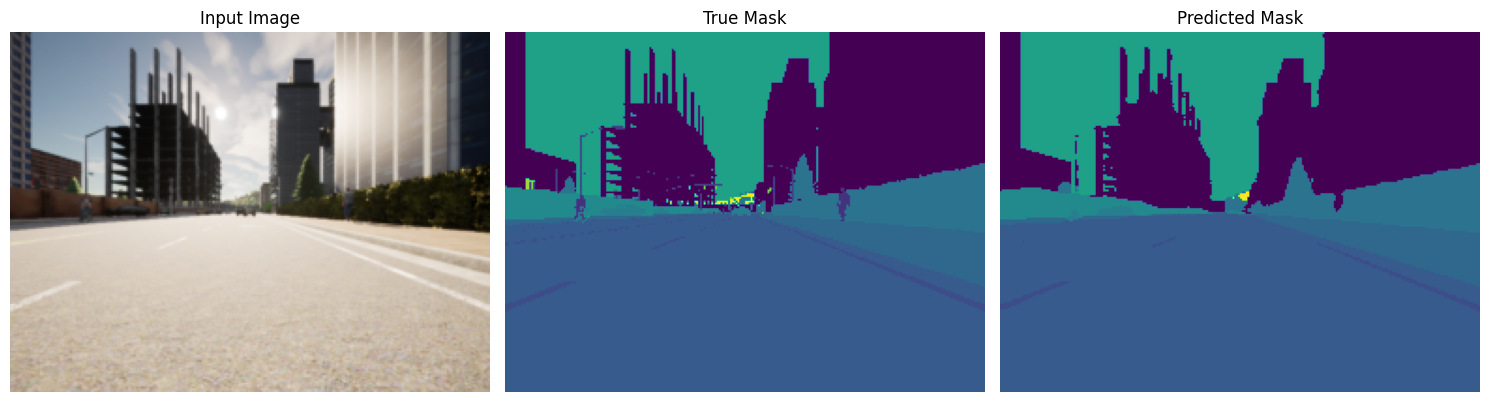

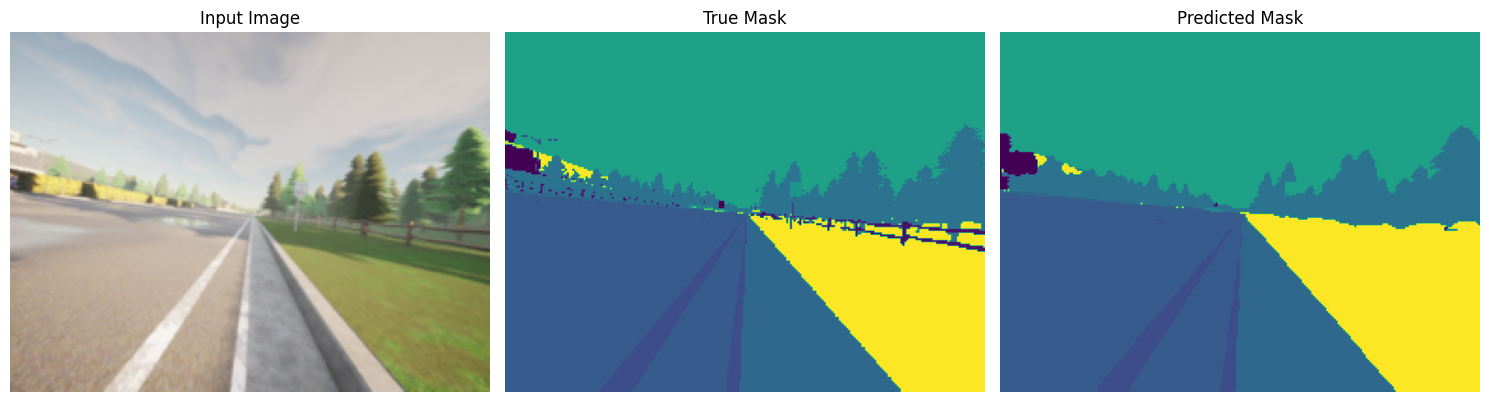

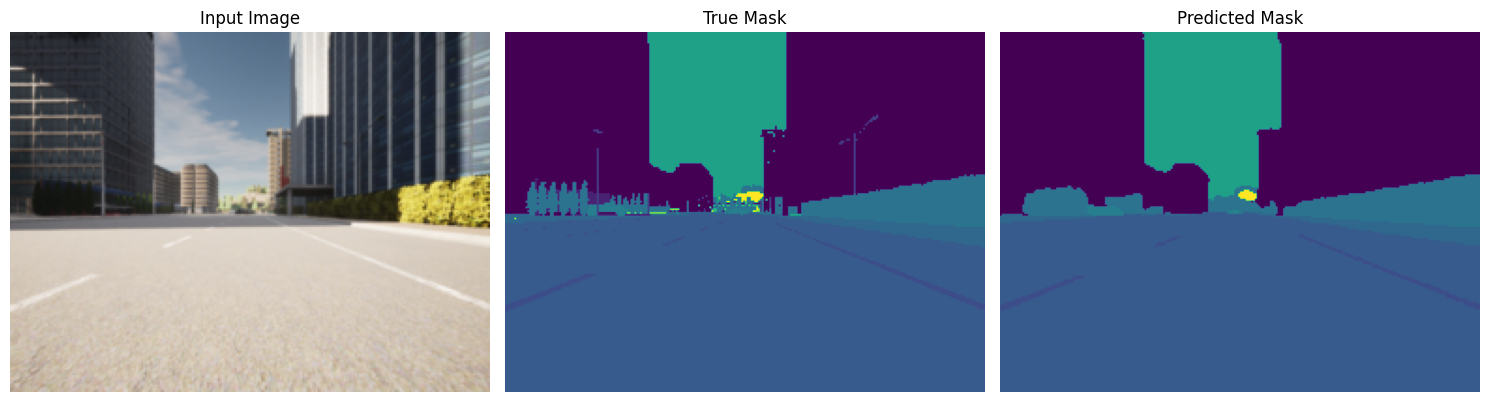

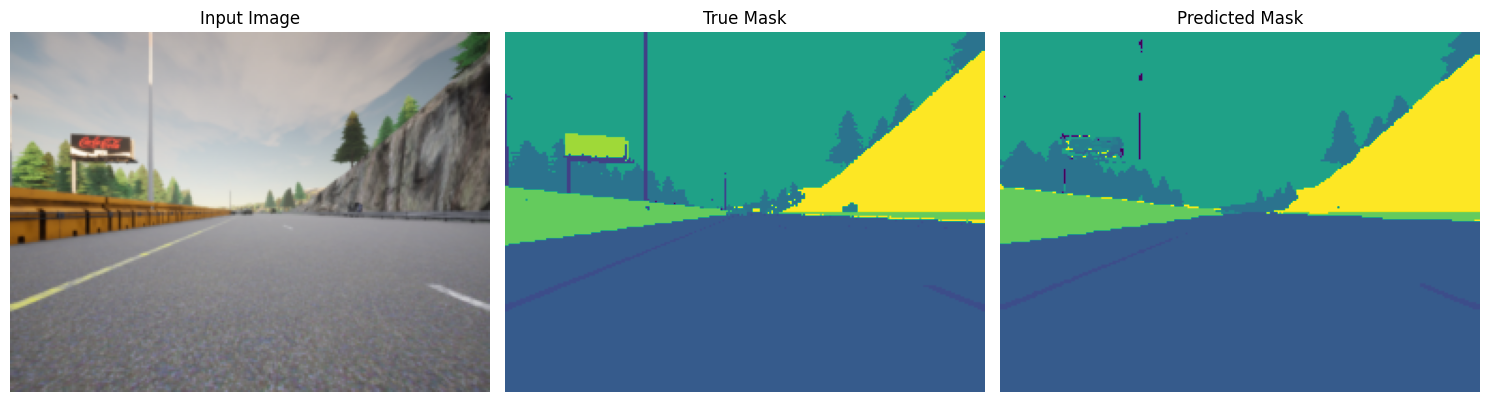

In [59]:
show_predictions(test_dataloader, device, 6)

## 5. Making the architecture better?!

Here, we want to try to make the UNet's model architecture, better. We try an approach named __Attention UNet__. This architecture tries to focus on the important parts of the image, and ignore the rest. Using this idea, we try to make the features (in `upsampling` steps) better, to finally reach a better __Decoder__ and thus, better predictions.

## 5.1 - Attention UNet

Here, is an overview of general architecture of Attention UNet:

<img src="./Images/1.png" style="width:100%;height:auto;">

As you can see, the architecture is similar to the UNet, but with the addition of Attention Gates. These gates are used to focus on the important parts of the image, and ignore the rest. But, what are these attention gates, precisely?!

<img src="./Images/2.png" style="width:100%;height:auto;">

As you can see, the attention gate is a simple architecture, which uses the features from the encoder, and the features from the decoder, adds them and also uses residual connections to output $\hat{x_l}$. Please note that $W_x \in \mathbb{R}^{F_l \times F_{int}}$, $W_g \in \mathbb{R}^{F_g \times F_{int}}$ and $\Psi \in \mathbb{R}^{F_{int} \times 1}$ are linear transformations which are being computed using channel-wise $1 \times 1 \times 1$ convolutions for the input tensors. In other contexts, this is called _vector concatenation-based attention_, where the concatenated features $x^l$ and $g$ are linearly mapped into a $\mathbb{R}^F_{int}$ dimensional _intermediate_ space.

Let's design the `AttentionBlock` class, which will be used in the `AttentionUNet` model:

In [60]:
class AttentionBlock(nn.Module):
    def __init__(self, F_l, F_int, F_g):
        super(AttentionBlock, self).__init__()
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1, stride=2)
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU()
        self.upsample = nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x, g):
        x_transformed = self.W_x(x)
        g_transformed = self.W_g(g)
        psi = self.psi(self.relu(x_transformed + g_transformed))
        psi_resized = self.upsample(psi)
        return x * psi_resized


You can define new `conv_block` and `upsample_block` to meet the requirements of the `AttentionUNet` model. If your previous `conv_block` and `upsample_block` functions are compatible, you can just use them!

In [61]:
class new_conv_block(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_prob=0):
        super(new_conv_block, self).__init__()
        self.dropout_prob = dropout_prob

        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)

        if self.dropout_prob == 0:
            return x
        return nn.functional.dropout2d(x, p=self.dropout_prob, training=self.training)


In [62]:
class new_upsample_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(new_upsample_block, self).__init__()

        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.norm = nn.BatchNorm2d(out_ch)
        self.conv = new_conv_block(in_ch=out_ch*2, out_ch=out_ch, dropout_prob=0)
        self.attention = AttentionBlock(F_l=out_ch, F_int=out_ch, F_g=in_ch)

    def forward(self, x, g):
        x_up_norm = self.norm(self.up(x))
        x_attention = self.attention(g, x)
        return self.conv(torch.cat([x_up_norm, x_attention], dim=1))

In [63]:
class UNet_With_Attention(nn.Module):
    def __init__(self, in_ch=3, out_ch=23):

        super().__init__()

        self.conv1 = new_conv_block(in_ch, 32, 0)
        self.conv2 = new_conv_block(32, 64, 0)
        self.conv3 = new_conv_block(64, 128, 0)
        self.conv4 = new_conv_block(128, 256, 0.5)
        self.conv5 = new_conv_block(256, 512, 0.5)
        self.max_pool = nn.MaxPool2d(2, 2)

        self.up1 = new_upsample_block(512, 256)
        self.up2 = new_upsample_block(256, 128)
        self.up3 = new_upsample_block(128, 64)
        self.up4 = new_upsample_block(64, 32)
        self.final = nn.Conv2d(32, out_ch, kernel_size=1)

    def forward(self, x):

        x1 = self.conv1(x)
        x2 = self.conv2(self.max_pool(x1))
        x3 = self.conv3(self.max_pool(x2))
        x4 = self.conv4(self.max_pool(x3))
        x5 = self.conv5(self.max_pool(x4))

        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)
        out = self.final(x9)
        return out

In [64]:
import torch.optim as optim
unet = UNet_With_Attention().to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2))
criterion = nn.CrossEntropyLoss()

Now, let's implement the training loop for our `Unet with Attention` model. (If you implemented a `train` function for previous part, you can simply reuse it here! If not, you can simply re-implement the loop)

In [65]:
import timeit
losses = []
unet.train()
def train_model():

    for epoch in range(EPOCHS):
        epoch_losses = []
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            pred = unet(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            print(f"EPOCH#{epoch},\t Batch#{i},\t Loss: {loss.item()}")
        losses.append(np.mean(epoch_losses))

start_time = timeit.default_timer()
train_model()
elapsed_time = timeit.default_timer() - start_time

print(f"Training completed in: {elapsed_time:.2f} seconds")

EPOCH#0,	 Batch#0,	 Loss: 3.3228628635406494
EPOCH#0,	 Batch#1,	 Loss: 3.1851141452789307
EPOCH#0,	 Batch#2,	 Loss: 3.0790510177612305
EPOCH#0,	 Batch#3,	 Loss: 2.9033520221710205
EPOCH#0,	 Batch#4,	 Loss: 2.7362773418426514
EPOCH#0,	 Batch#5,	 Loss: 2.596087694168091
EPOCH#0,	 Batch#6,	 Loss: 2.4235360622406006
EPOCH#0,	 Batch#7,	 Loss: 2.2817397117614746
EPOCH#0,	 Batch#8,	 Loss: 2.1744277477264404
EPOCH#0,	 Batch#9,	 Loss: 2.0558669567108154
EPOCH#0,	 Batch#10,	 Loss: 1.9487508535385132
EPOCH#0,	 Batch#11,	 Loss: 1.8730272054672241
EPOCH#0,	 Batch#12,	 Loss: 1.8783472776412964
EPOCH#0,	 Batch#13,	 Loss: 1.794950008392334
EPOCH#0,	 Batch#14,	 Loss: 1.7800970077514648
EPOCH#0,	 Batch#15,	 Loss: 1.7437628507614136
EPOCH#0,	 Batch#16,	 Loss: 1.718663215637207
EPOCH#0,	 Batch#17,	 Loss: 1.717538833618164
EPOCH#0,	 Batch#18,	 Loss: 1.6869996786117554
EPOCH#0,	 Batch#19,	 Loss: 1.6037425994873047
EPOCH#0,	 Batch#20,	 Loss: 1.6230255365371704
EPOCH#0,	 Batch#21,	 Loss: 1.5758129358291626
EP

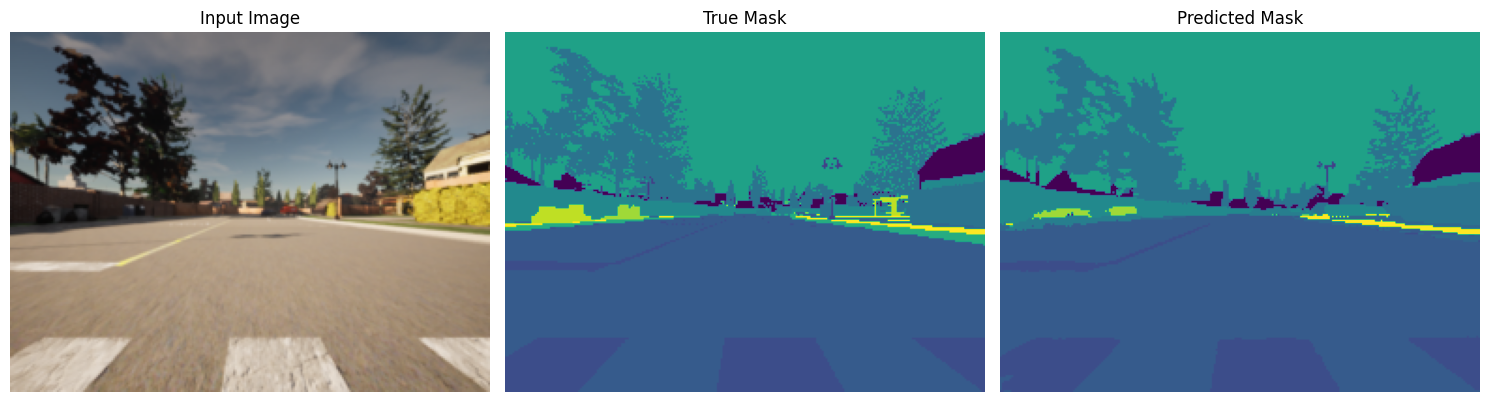

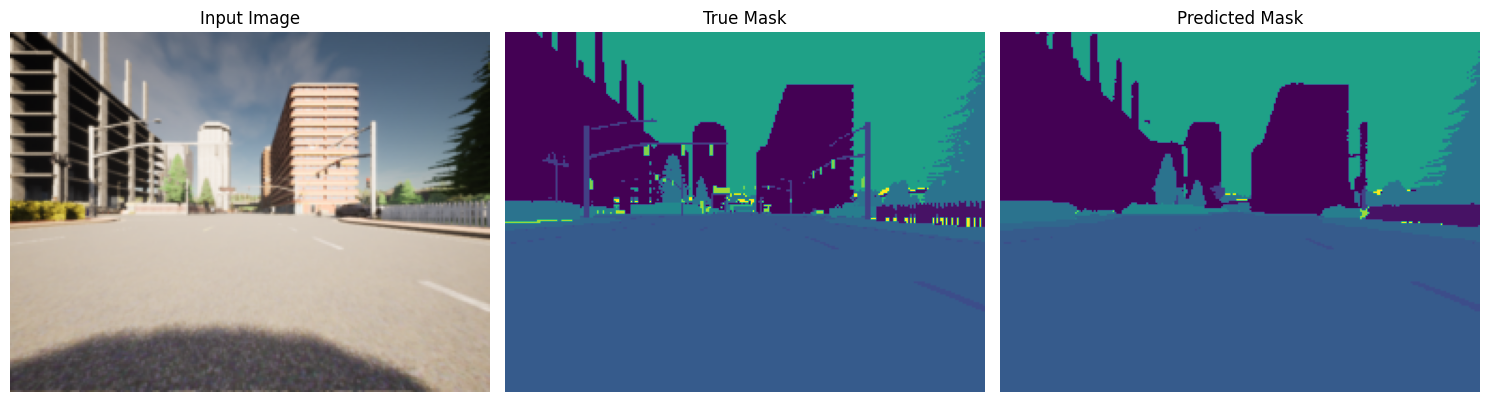

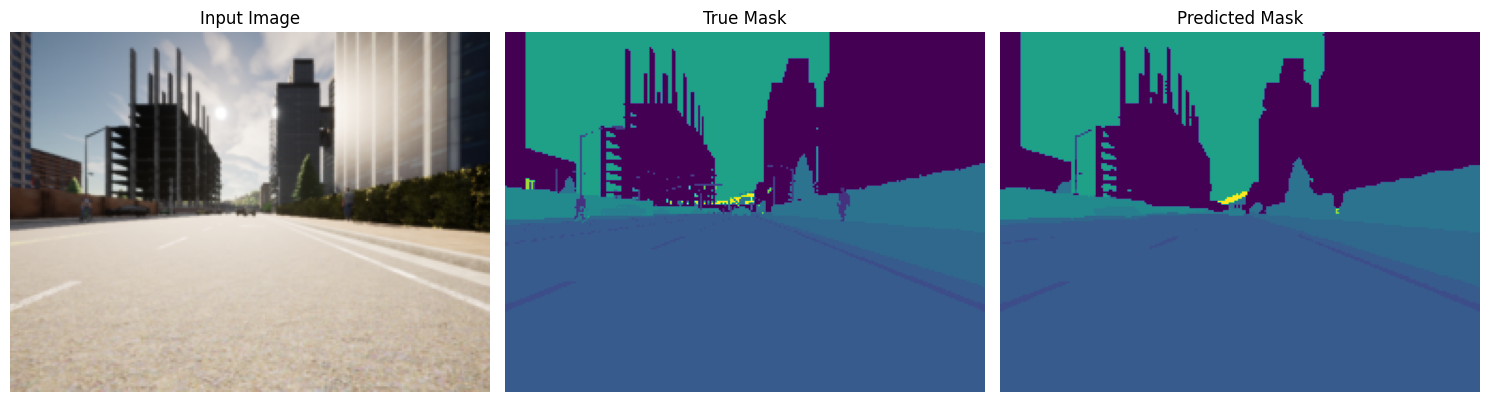

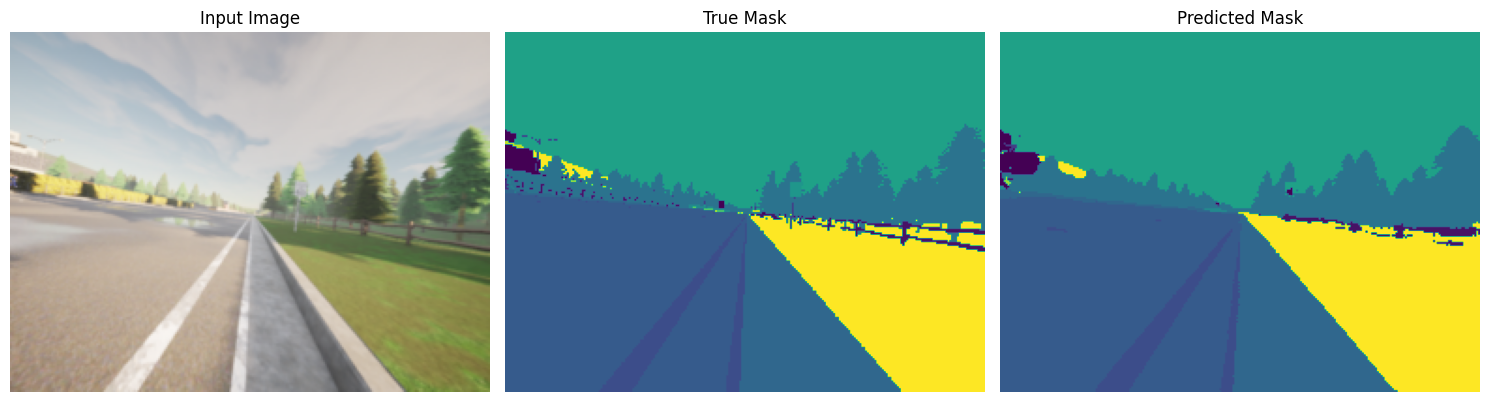

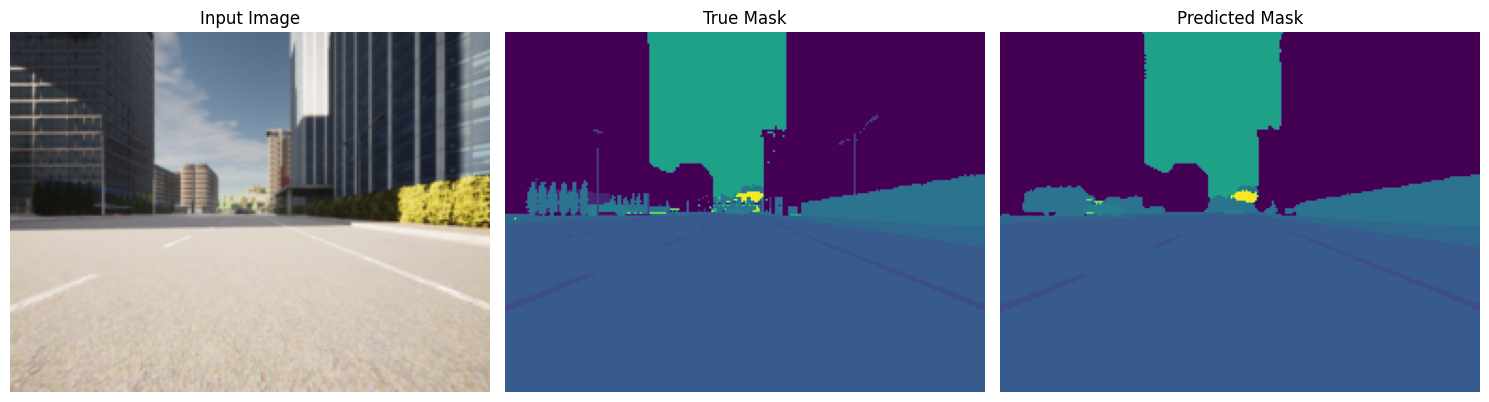

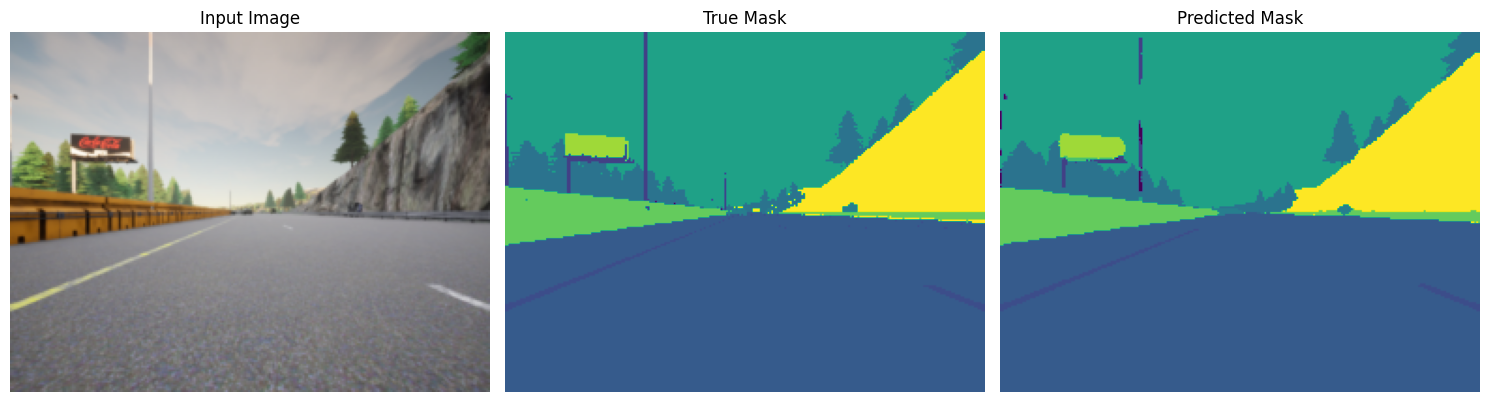

In [66]:
show_predictions(test_dataloader, device, 6)

Now, let's plot the `losses` vs `epochs` for the `AttentionUNet` model.

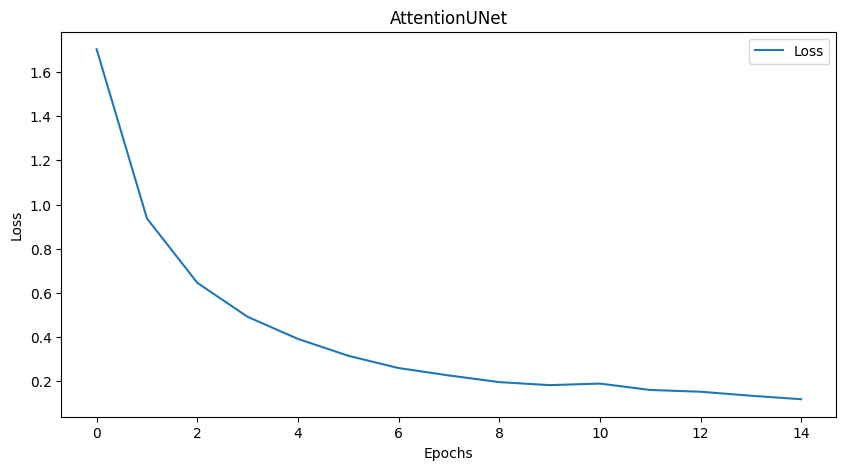

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(range(EPOCHS), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('AttentionUNet')
plt.legend()
plt.show()

<a name='5-2'></a>
### 5.2 - mIoU

calculate mIoU for test dataset images with new model using the defined function above and report average mIoU for all the images.

In [68]:
# num_classes = 23
# mious = []
# for i, batch in enumerate(test_dataloader):
#   with torch.no_grad():
#     image = batch
#     y_pred = unet(image["IMAGE"].to(torch.float32).to(device))
#     _, y_pred = torch.max(y_pred, 1, keepdim=True)

#     y_true = np.array(image["MASK"])
#     y_pred = (y_pred.cpu().detach().numpy())

#     miou = calculate_miou(y_true, y_pred, num_classes)
#     mious.append(miou)

# print(f"average miou for test dataset: {sum(mious) / len(mious)}")

num_classes = 23
mious = []

for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        X, y_true = batch
        X = X.to(device)
        y_true = y_true.to(device)

        y_pred = unet(X)
        _, y_pred = torch.max(y_pred, dim=1)

        y_true = y_true.cpu().numpy()
        y_pred = y_pred.cpu().numpy()

        miou = calculate_miou(y_true, y_pred, num_classes)
        mious.append(miou)

average_miou = sum(mious) / len(mious)
print(f"Average mIoU for test dataset: {average_miou:}")

Average mIoU for test dataset: 0.4842783959506504


### 5.3
Compare the results between `Unet` and `AttentionUNet` models. Do your comparison in terms of `mIoU` and `loss` values, and also the `training time`. Which one is better in each of these metrics? Explain your answer based on the outputs and plots and loss values and mIoU values.

**Answer**:

## Project Report

During the execution of the two mentioned phases in the project, first, we used the same dimensions in sections 4 and 5, so that our bottleneck had dimensions of 256 by 512, and to compare the performance of these two sections, it was necessary for these dimensions to be identical.

Furthermore, based on several parameters, including Learning Rate, Batch Size, B1, and B2, we initialized the values. We considered the number of Epochs to be 15 and the Batch Size to be 16, and we implemented this with LR = 0.0004 and B1 = 0.9, B2 = 0.999.
We observed that increasing the Batch Size significantly extends the execution time, and similarly, increasing the Learning Rate further makes the Loss curve lose its smoothness. Conversely, the smaller the Learning Rate, for instance, around 0.0001, the smoother the curve becomes, and it seems to perform better, although the execution time increases again.

Therefore, we chose 0.0004 as the appropriate value.

Next, we observed that the time taken to calculate the losses was about 184 seconds for section 4 and about 216 seconds for section 5, which is logical because in section 5, due to the Attention Gates and increased complexity, it takes longer.

Now we move on to comparing the mIoU. As observed, in the Attention model, this value is higher, around 0.484, whereas in the standard UNet, this value is about 0.384.

By comparing the obtained Loss curves, it is also observed that in the Attention model, the Loss value is lower than that of the standard UNet.

Thus, it is generally observed that using the Attention model leads to an overall improvement in the estimated images.

Note that by changing the hyperparameters or using a different model in the Conv_blocks or Upsample_blocks, we can achieve models with different characteristics, and it seems that what we have achieved is a desirable model.